In [26]:
import geopandas
import matplotlib
import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from geopy import distance
import numpy as np
import pysal as ps
import folium

In [27]:
# turn on the interactive mode of matplotlib
plt.ion()


# change the figure size
plt.rcParams['figure.figsize'] = [20, 20]

In [28]:
# read the shapefile stored in my computer using the absolute (full) path
tract = geopandas.read_file("D:/airbnb/GIS_data/oahu_tract.shp")
listing = pd.read_csv('D:/airbnb/tables/listings.csv')

In [29]:
tract.columns

Index([  u'OBJECTID',    u'STATEFP',   u'COUNTYFP',    u'TRACTCE',
            u'GEOID',       u'NAME',   u'NAMELSAD',      u'MTFCC',
         u'FUNCSTAT',      u'ALAND',     u'AWATER',   u'INTPTLAT',
         u'INTPTLON', u'Shape_Leng', u'Shape_Area', u'GEOID_Data',
       u'area_sqr_m',    u'pop_den',   u'geometry'],
      dtype='object')

In [30]:
tract = tract.drop(columns=['OBJECTID','MTFCC','FUNCSTAT','INTPTLAT','INTPTLON', 'Shape_Leng'])

In [31]:
listing.columns

Index([u'id', u'listing_url', u'scrape_id', u'last_scraped', u'name',
       u'summary', u'space', u'description', u'experiences_offered',
       u'neighborhood_overview', u'notes', u'transit', u'access',
       u'interaction', u'house_rules', u'thumbil_url', u'medium_url',
       u'picture_url', u'xl_picture_url', u'host_id', u'host_url',
       u'host_name', u'host_since', u'host_location', u'host_about',
       u'host_response_time', u'host_response_rate', u'host_acceptance_rate',
       u'host_is_superhost', u'host_thumbnail_url', u'host_picture_url',
       u'host_neighbourhood', u'host_listings_count',
       u'host_total_listings_count', u'host_verifications',
       u'host_has_profile_pic', u'host_identity_verified', u'street',
       u'neighbourhood', u'neighbourhood_cleansed',
       u'neighbourhood_group_cleansed', u'city', u'state', u'zipcode',
       u'market', u'smart_location', u'country_code', u'country', u'latitude',
       u'longitude', u'is_location_exact', u'propert

Convert the listing into a geodataframe

In [32]:
geometry = [Point(xy) for xy in zip(listing.longitude, listing.latitude)]
crs = tract.crs #get tract polygon files crs
geo_listing = GeoDataFrame(listing, crs=crs, geometry=geometry)
# geo_df.to_file(driver='ESRI Shapefile', filename='data.shp') # write to a shapefile

In [33]:
geo_listing = geopandas.sjoin(geo_listing,tract,op = "intersects")

** Get number of airbnb per census tract **

In [34]:
a = geo_listing.groupby(["GEOID_Data"], as_index=False).count()
a = a[['GEOID_Data', 'STATEFP']]
a.rename(columns={'STATEFP':'count'}, inplace=True)
tract = tract.merge(a, how='left', on='GEOID_Data')

** Get get number of shared room and entire houses **

In [35]:
a2 = geo_listing[['GEOID_Data','room_type','GEOID']]
a2 = a2.groupby(["GEOID_Data",'room_type']).count()
a2 = a2.reset_index()
pr = a2[a2['room_type']=="Private room"]
eh = a2[a2['room_type']=="Entire home/apt"]
sr = a2[a2['room_type']=="Shared room"]
pr = pr.drop(columns='room_type')
eh = eh.drop(columns='room_type')
sr = sr.drop(columns='room_type')

pr.columns=['GEOID_Data','pr_count']
eh.columns=['GEOID_Data','eh_count']
sr.columns=['GEOID_Data','sr_count']

tract = tract.merge(pr,how='left', on='GEOID_Data')
tract = tract.merge(sr,how='left', on='GEOID_Data')
tract = tract.merge(eh,how='left', on='GEOID_Data')

tract['r_private_room'] = tract['pr_count']/tract['count']
tract['r_shared_room'] = tract['sr_count']/tract['count']
tract['r_entire_home'] = tract['eh_count']/tract['count']

tract=tract.drop(columns=['pr_count','sr_count','eh_count'])

** Calculate average price per bed **

In [36]:
geo_listing['beds'][geo_listing['beds']==0]=geo_listing['bedrooms']
geo_listing['beds'][geo_listing['beds']==0]=geo_listing['accommodates']
geo_listing['price_per_bed'] = geo_listing['price']/geo_listing['beds']
avg_price = geo_listing.groupby(["GEOID_Data"], as_index=False).mean()
avg_price=avg_price[['GEOID_Data','price_per_bed']]
tract = tract.merge(avg_price, how='left',on='GEOID_Data')


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [37]:
pr_type = geo_listing.groupby(["property_type"], as_index=False).count()
pr_type['property_type'][pr_type['STATEFP']<500]='others'
pr_type = pr_type.groupby(["property_type"], as_index=False).sum()
pr_type.rename(columns={'STATEFP':'count'}, inplace=True)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [38]:
pr_type

,property_type,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,...,GEOID,NAME,NAMELSAD,ALAND,AWATER,Shape_Area,GEOID_Data,area_sqr_m,pop_den,price_per_bed
0,Apartment,1747,1747,1747,1747,1746,1705,1393,1733,1747,...,1747,1747,1747,1747,1747,1747,1747,1747,1747,1747
1,Condominium,2816,2816,2816,2816,2816,2797,2372,2802,2816,...,2816,2816,2816,2816,2816,2816,2816,2816,2816,2815
2,Guest suite,519,519,519,519,519,514,467,519,519,...,519,519,519,519,519,519,519,519,519,519
3,House,2176,2176,2176,2176,2176,2118,1806,2161,2176,...,2176,2176,2176,2176,2176,2176,2176,2176,2176,2175
4,others,1278,1278,1278,1278,1278,1251,1030,1266,1278,...,1278,1278,1278,1278,1278,1278,1278,1278,1278,1277


Text(0.5,1,'Different property types of airbnb')

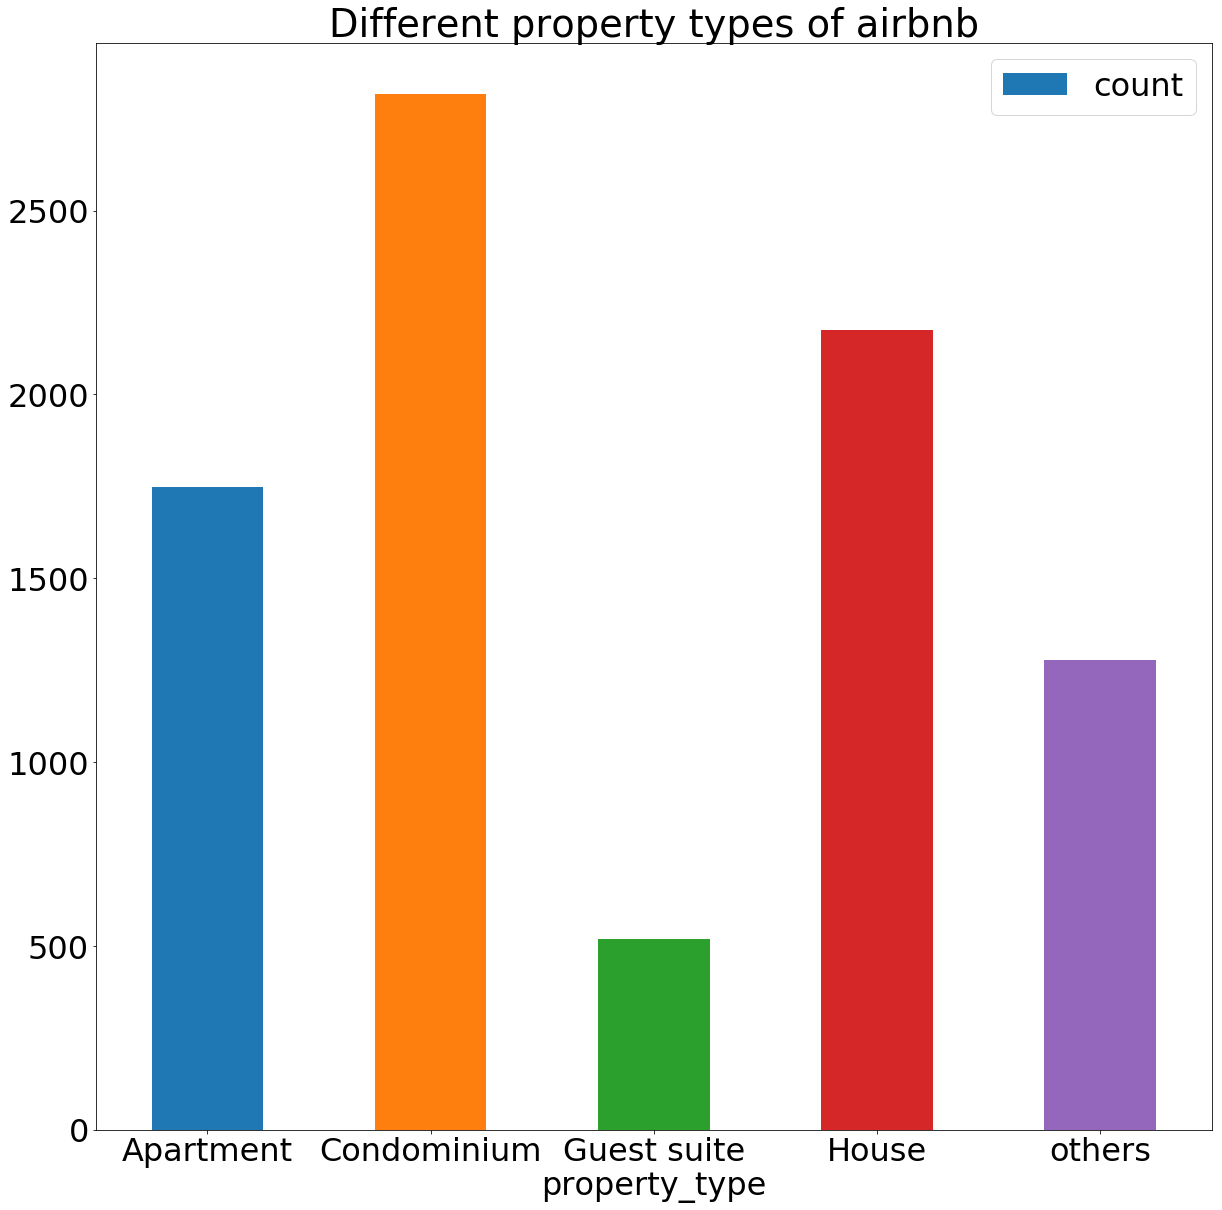

In [39]:
matplotlib.rcParams.update({'font.size': 32})

pr_type.plot.bar(x='property_type', y='count', rot=0)
plt.title('Different property types of airbnb')

In [40]:
geo_listing.columns

Index([                   u'id',           u'listing_url',
                   u'scrape_id',          u'last_scraped',
                        u'name',               u'summary',
                       u'space',           u'description',
         u'experiences_offered', u'neighborhood_overview',
       ...
                       u'GEOID',                  u'NAME',
                    u'NAMELSAD',                 u'ALAND',
                      u'AWATER',            u'Shape_Area',
                  u'GEOID_Data',            u'area_sqr_m',
                     u'pop_den',         u'price_per_bed'],
      dtype='object', length=113)

In [41]:
tf = (~np.isnan(geo_listing['Lat']))&(~np.isnan(geo_listing['Lat']))
geo_listing2=geo_listing[tf]

In [42]:
list_coords = zip(geo_listing2['latitude'],geo_listing2['longitude'])
home_coords = zip(geo_listing2['Lat'],geo_listing2['Lon'])
dist = map(distance.distance,home_coords,list_coords)
dist = [o.miles for o in dist]

geo_listing2['dist']=dist
geo_listing2 = geo_listing2[['id','dist']]
geo_listing = geo_listing.merge(geo_listing2,how='left', on='id')

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


** Different room types **

Text(0.5,1,'Room types')

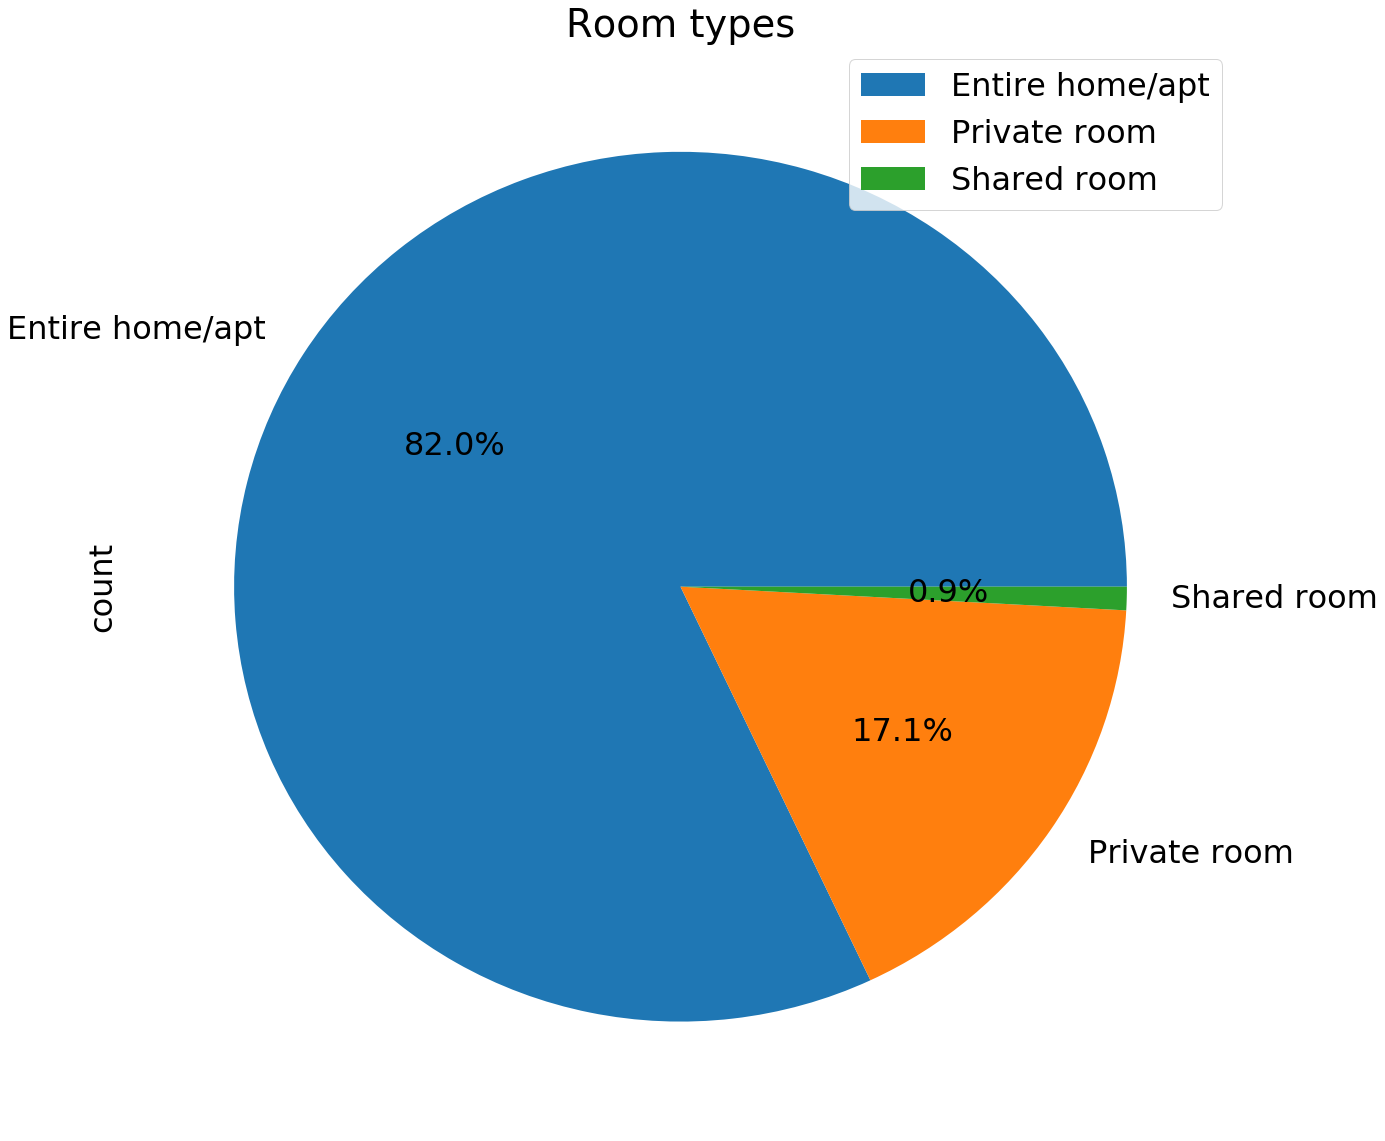

In [43]:
room_type = geo_listing.groupby(["room_type"], as_index=False).count()
room_type = room_type.groupby(["room_type"], as_index=False).sum()
room_type.rename(columns={'STATEFP':'count'}, inplace=True)

room_type.plot.pie(y='count',autopct='%1.1f%%',labels=room_type['room_type'])
plt.title('Room types')

** Calculate local owners and offshore owners per tract**

In [44]:
geo_listing['owner_loc']=''
geo_listing['owner_loc'][geo_listing['dist']<=400]='local'
geo_listing['owner_loc'][geo_listing['dist']>400]='off_shore'

geo_listing2 = geo_listing[['GEOID_Data','dist','owner_loc']]
avg_dist = geo_listing2.groupby(["GEOID_Data"], as_index=False).mean()
owner_loc = geo_listing2.groupby(["GEOID_Data",'owner_loc'], as_index=False).count()

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


** Local and off_shore owners**

Text(0.5,1,'Owner locations')

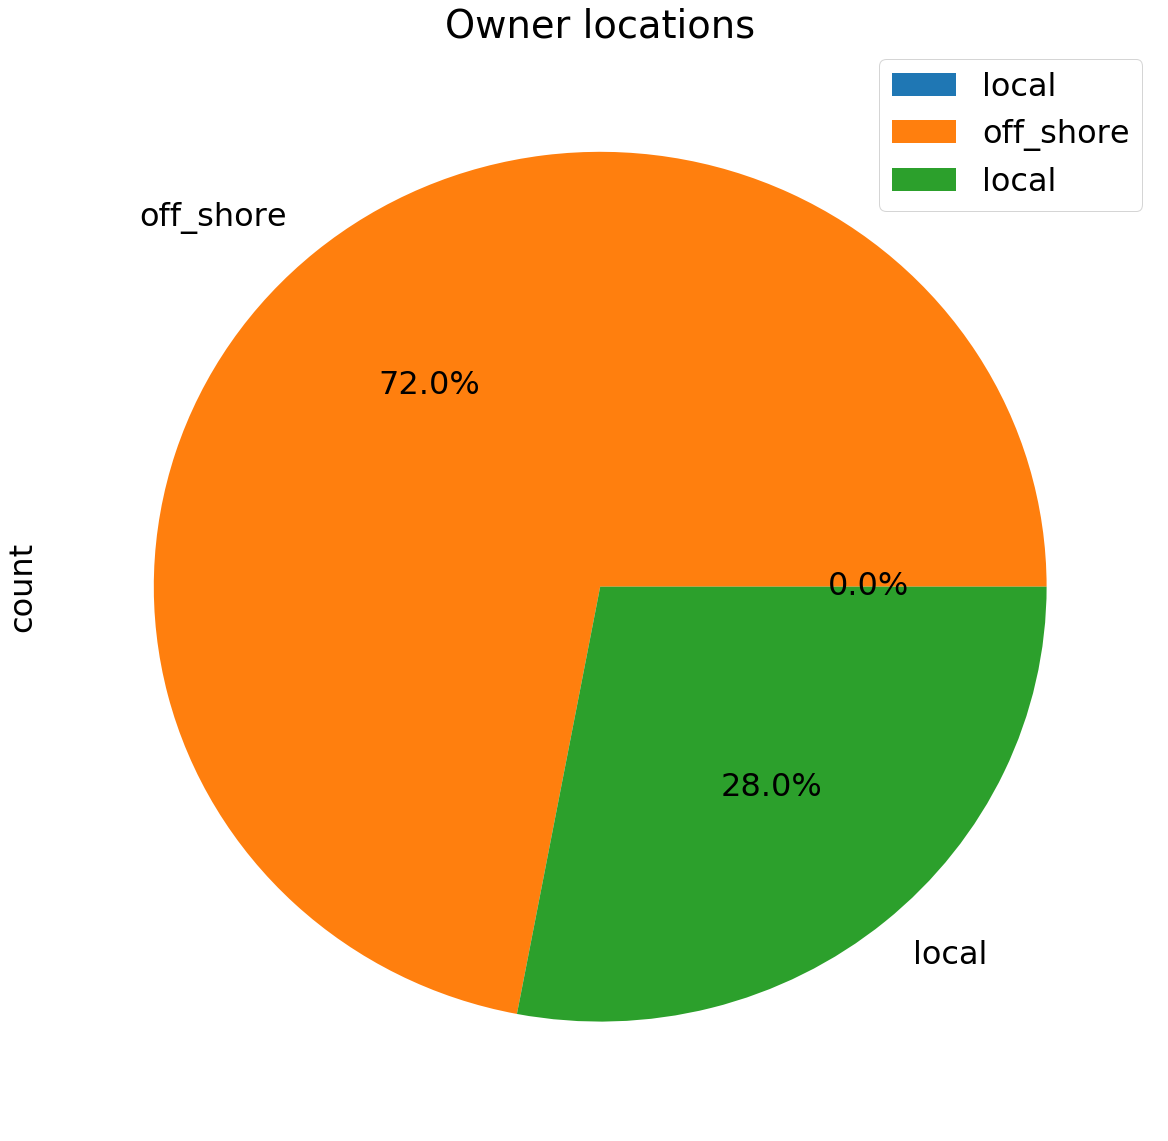

In [45]:
owner_loc2 = geo_listing2.groupby(["owner_loc"], as_index=False).count()
owner_loc2.rename(columns={'dist':'count'}, inplace=True)

owner_loc2.plot.pie(y='count',autopct='%1.1f%%',labels=owner_loc['owner_loc'])
plt.title('Owner locations')

** Calculate ratio of local owners per census tract **

In [46]:
local_owner = owner_loc[owner_loc['owner_loc']=='local']
local_owner.rename(columns={'dist':'local_owner'}, inplace=True)
local_owner = local_owner.drop(columns=['owner_loc'])

offshore_owner = owner_loc[owner_loc['owner_loc']=='off_shore']
offshore_owner.rename(columns={'dist':'offshore_owner'}, inplace=True)
offshore_owner = offshore_owner.drop(columns=['owner_loc'])

local_owner = local_owner.merge(offshore_owner,how='left',on='GEOID_Data')

tract= tract.merge(local_owner, how='left', on='GEOID_Data')

In [47]:
tract.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,ALAND,AWATER,Shape_Area,GEOID_Data,area_sqr_m,pop_den,geometry,count,r_private_room,r_shared_room,r_entire_home,price_per_bed,local_owner,offshore_owner
0,15,003,011106,15003011106,111.06,Census Tract 111.06,3827214.0,30252.0,0.000336,14000US15003011106,1.47769,3920.980,POLYGON ((-157.7366940000281 21.35918599973417...,44.0,0.227273,0.022727,0.750000,85.741504,36.0,6.0
1,15,003,000200,15003000200,2,Census Tract 2,10042118.0,666763.0,0.000932,14000US15003000200,3.87728,1434.770,POLYGON ((-157.7445129999749 21.28044399999067...,46.0,0.282609,NaN,0.717391,132.645080,40.0,6.0
2,15,003,000106,15003000106,1.06,Census Tract 1.06,7900462.0,0.0,0.000688,14000US15003000106,3.05038,2621.640,POLYGON ((-157.7235570003552 21.31823199970705...,32.0,0.312500,NaN,0.687500,100.792485,25.0,7.0
3,15,003,006702,15003006702,67.02,Census Tract 67.02,422504.0,0.0,0.000037,14000US15003006702,0.16313,15601.100,"POLYGON ((-157.907992999877 21.36857400009006,...",1.0,1.000000,NaN,NaN,900.000000,NaN,NaN
4,15,003,009100,15003009100,91,Census Tract 91,32962539.0,205570.0,0.002891,14000US15003009100,12.72690,415.184,POLYGON ((-158.0611890003721 21.50792000040775...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


** Attach census data **

In [48]:
# Read population table
population = pd.read_csv('D:\census_data\hawaii/ACS_17_5YR_B01003_with_ann.csv', encoding="cp1252")
population['GEO.id'] = population['GEO.id'].str.replace('1400000US', '14000US', regex=False)
population =population.drop(columns=['HD02_VD01','GEO.id2','GEO.display-label','HD02_VD01'])
population.rename(columns={'HD01_VD01':'pop17'}, inplace=True)

# Read housing units table
housing_unit = pd.read_csv('D:\census_data\hawaii/ACS_17_5YR_B25001_with_ann.csv', encoding="cp1252")
housing_unit['GEO.id'] = housing_unit['GEO.id'].str.replace('1400000US', '14000US', regex=False)
housing_unit =housing_unit.drop(columns=['HD02_VD01','GEO.id2','GEO.display-label','HD02_VD01'])
housing_unit.rename(columns={'HD01_VD01':'h_units'}, inplace=True)

# Read household table
household = pd.read_csv('D:\census_data\hawaii/ACS_17_5YR_S1101_with_ann.csv', encoding="cp1252")
household['GEO.id'] = household['GEO.id'].str.replace('1400000US', '14000US', regex=False)
household =household[['GEO.id','HC01_EST_VC02','HC02_EST_VC02']]
household.rename(columns=dict(zip(['HC01_EST_VC02','HC02_EST_VC02'],['household','married_household'])), inplace=True)
household['r_married_household']=household['married_household']/household['household']

population = population.merge(housing_unit,how='left',on='GEO.id')
population = population.merge(household,how='left',on='GEO.id')
tract = tract.merge(population,how='left',left_on='GEOID_Data',right_on='GEO.id')

In [49]:
tract.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,ALAND,AWATER,Shape_Area,GEOID_Data,...,r_entire_home,price_per_bed,local_owner,offshore_owner,GEO.id,pop17,h_units,household,married_household,r_married_household
0,15,003,011106,15003011106,111.06,Census Tract 111.06,3827214.0,30252.0,0.000336,14000US15003011106,...,0.750000,85.741504,36.0,6.0,14000US15003011106,5680,1850,1791,1169,0.652708
1,15,003,000200,15003000200,2,Census Tract 2,10042118.0,666763.0,0.000932,14000US15003000200,...,0.717391,132.645080,40.0,6.0,14000US15003000200,5648,1925,1742,1063,0.610218
2,15,003,000106,15003000106,1.06,Census Tract 1.06,7900462.0,0.0,0.000688,14000US15003000106,...,0.687500,100.792485,25.0,7.0,14000US15003000106,7893,3451,3156,1789,0.566857
3,15,003,006702,15003006702,67.02,Census Tract 67.02,422504.0,0.0,0.000037,14000US15003006702,...,NaN,900.000000,NaN,NaN,14000US15003006702,2507,1187,1113,469,0.421384
4,15,003,009100,15003009100,91,Census Tract 91,32962539.0,205570.0,0.002891,14000US15003009100,...,NaN,NaN,NaN,NaN,14000US15003009100,5216,1196,1149,585,0.509138


** Attach Twitter data **

In [50]:
# Read data
twitter = pd.read_csv('E:/Twitter/airbnb/state_of_hawaii_may_tour_bbox.csv')

# eliminate the unidentified tweets
twitter = twitter[twitter['tour']!='unidentified']

C:\ProgramData\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2718: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [51]:
geometry = [Point(xy) for xy in zip(twitter.lng, twitter.lat)]
crs = tract.crs #get tract polygon files crs
geo_twitter = GeoDataFrame(twitter, crs=crs, geometry = geometry)
# geo_df.to_file(driver='ESRI Shapefile', filename='data.shp') # write to a shapefile

# spatial join tweets to census tract
geo_twitter = geopandas.sjoin(geo_twitter,tract,op = "intersects")
geo_twitter=geo_twitter.drop(columns=['ALAND','NAMELSAD'])

In [52]:
tourist = geo_twitter[(geo_twitter['tour']=='Qtourist')|(geo_twitter['tour']=='tourist')]
tourist = tourist.groupby(["GEOID_Data"], as_index=False).count()
tourist = tourist[['GEOID_Data','X']]
tourist.rename(columns={'X':'tourist'}, inplace=True)

non_tourist = geo_twitter[geo_twitter['tour']=='resident']
non_tourist = non_tourist.groupby(["GEOID_Data"], as_index=False).count()
non_tourist = non_tourist[['GEOID_Data','X']]
non_tourist.rename(columns={'X':'non_tourist'}, inplace=True)

tourist = non_tourist.merge(tourist,how='outer',on='GEOID_Data')

In [53]:
tourist['all_tweets']=tourist['non_tourist'] + tourist['tourist']
tourist['r_tourist']=tourist['tourist']/tourist['all_tweets']

In [54]:
tract = tract.merge(tourist,how='left',on='GEOID_Data')

# Mapping

In [55]:
tract['count'][np.isnan(tract['count'])]=0

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [56]:
# Calculate airbnb per housing unit
tract['cp_housing_units'] = tract['count']/tract['h_units']
tract['cp_household'] = tract['count']/tract['household']

In [57]:
tract['cp_housing_units'][~np.isfinite(tract['cp_housing_units'])] = np.nan
tract['cp_household'][~np.isfinite(tract['cp_household'])] = np.nan

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [58]:
tract.columns

Index([            u'STATEFP',            u'COUNTYFP',             u'TRACTCE',
                     u'GEOID',                u'NAME',            u'NAMELSAD',
                     u'ALAND',              u'AWATER',          u'Shape_Area',
                u'GEOID_Data',          u'area_sqr_m',             u'pop_den',
                  u'geometry',               u'count',      u'r_private_room',
             u'r_shared_room',       u'r_entire_home',       u'price_per_bed',
               u'local_owner',      u'offshore_owner',              u'GEO.id',
                     u'pop17',             u'h_units',           u'household',
         u'married_household', u'r_married_household',         u'non_tourist',
                   u'tourist',          u'all_tweets',           u'r_tourist',
          u'cp_housing_units',        u'cp_household'],
      dtype='object')

Text(0,0.5,'counts')

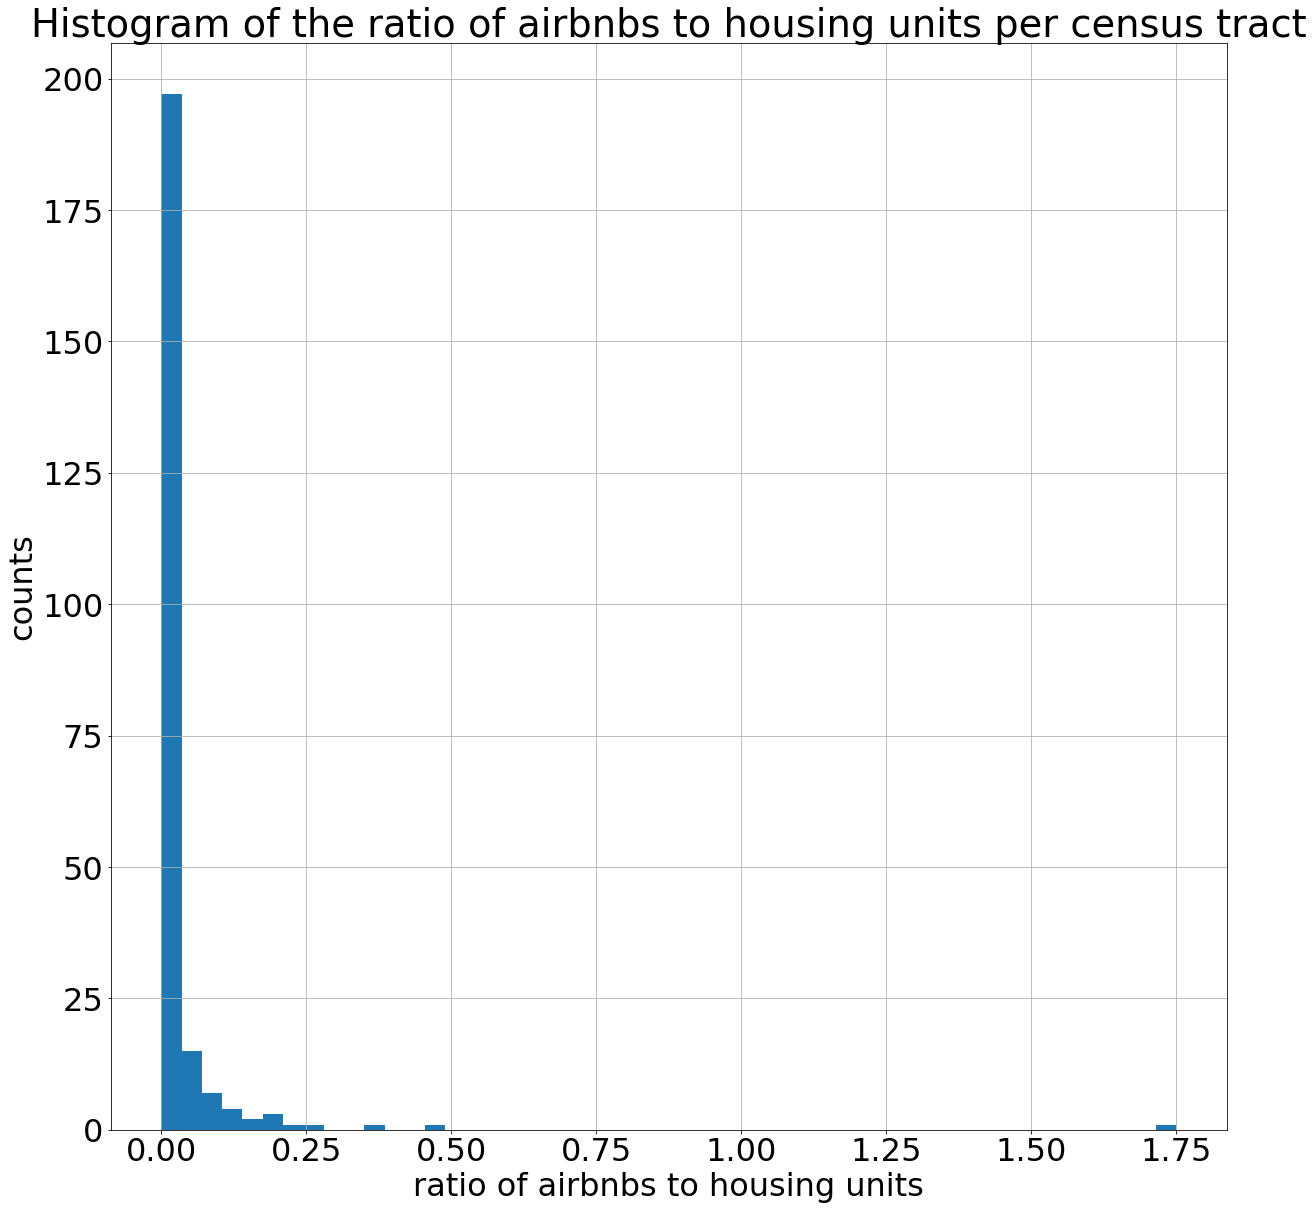

In [59]:
tract['cp_housing_units'].hist(bins=50)
plt.title('Histogram of the ratio of airbnbs to housing units per census tract')
plt.xlabel('ratio of airbnbs to housing units')
plt.ylabel('counts')

Text(0.5,1,'Ratio of airbnbs to housing units per census tract')

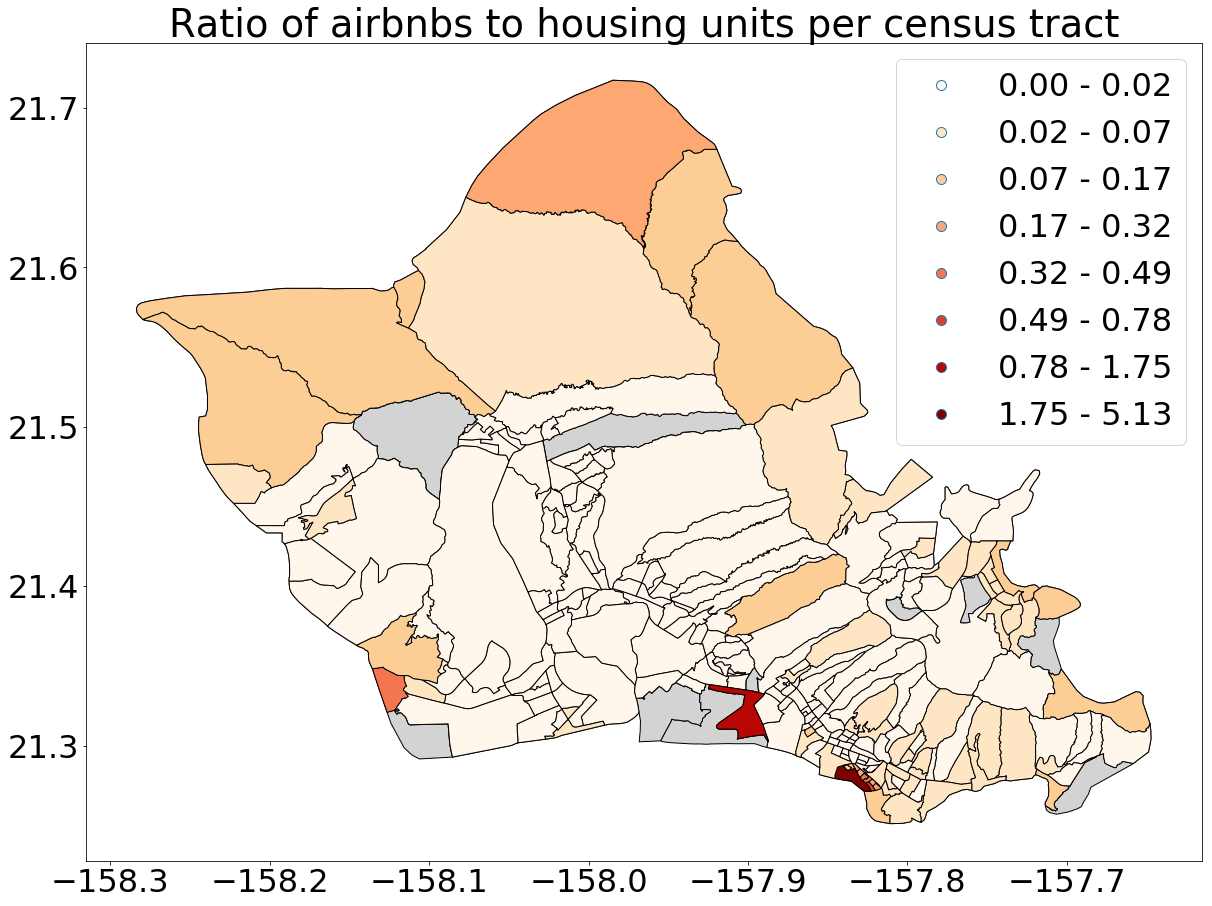

In [60]:
ax = tract.plot(color="lightgrey",linewidth=1, edgecolor='black')
tract2 = tract[~np.isnan(tract['cp_household'])]
tract2.plot(ax=ax,column='cp_household',cmap='OrRd', scheme='fisher_jenks',k=8, linewidth=1, edgecolor='black', legend=True)
plt.title('Ratio of airbnbs to housing units per census tract')

Text(0.5,1,'Airbnb of different room types')

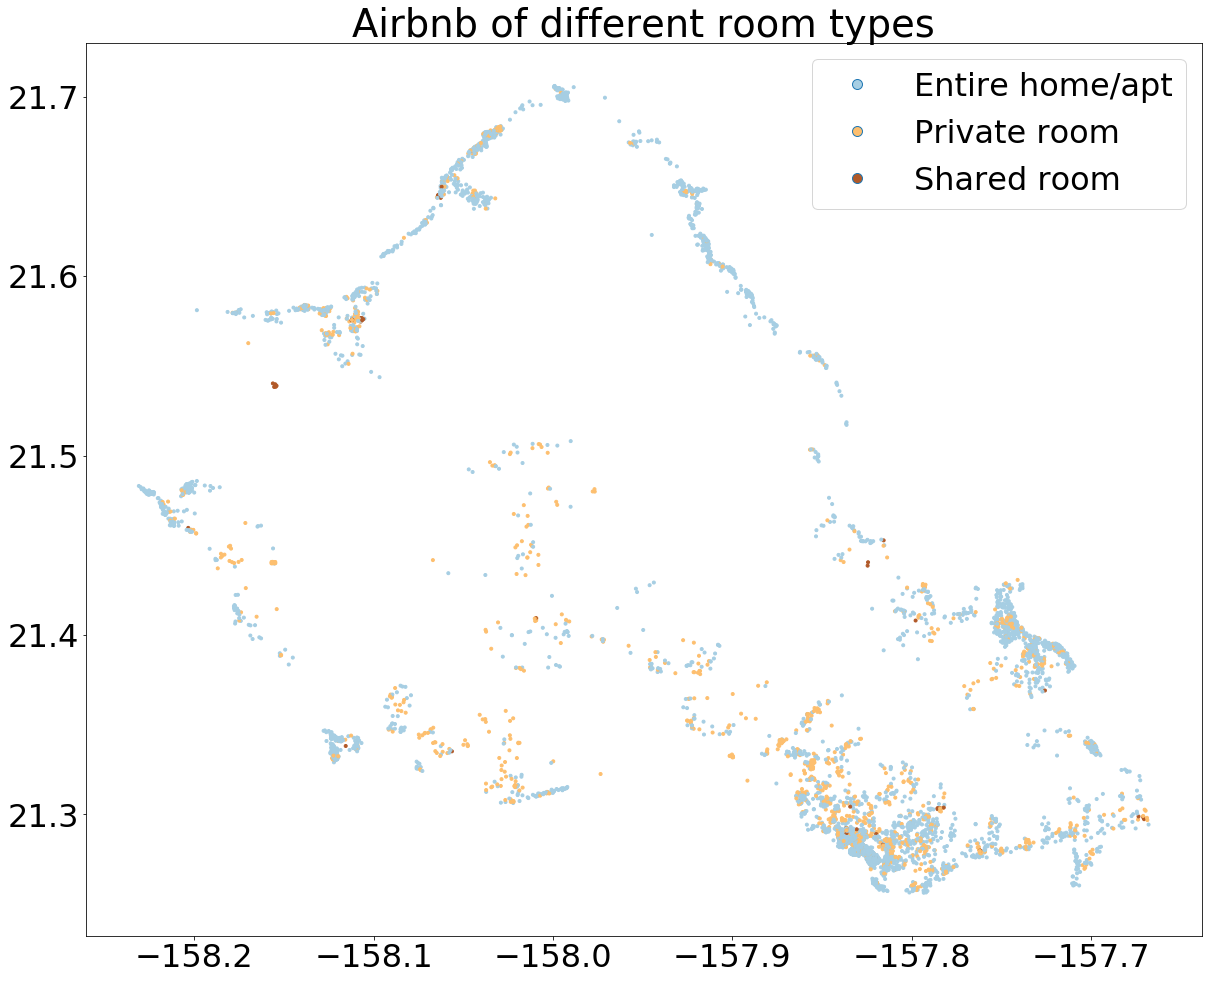

In [61]:
geo_listing.plot(marker='.',column='room_type',cmap='Paired',legend=True)
plt.title('Airbnb of different room types')

Text(0.5,1,'Ratio of entire homes in all airbnbs by census tract')

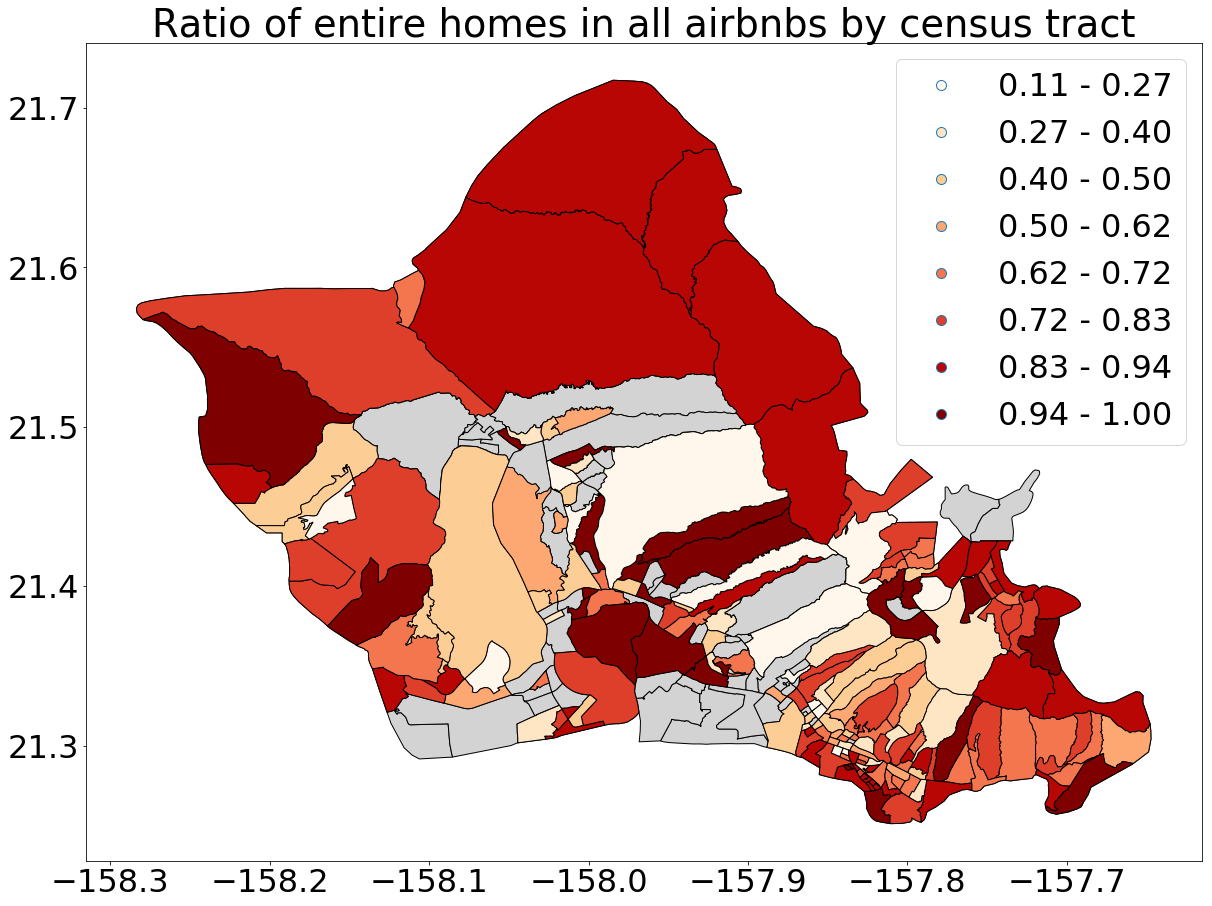

In [62]:
ax = tract.plot(color="lightgrey",linewidth=1, edgecolor='black')
tract2 = tract[~np.isnan(tract['r_entire_home'])]
tract2.plot(ax=ax,column='r_entire_home',cmap='OrRd', scheme='fisher_jenks',k=8, linewidth=1, edgecolor='black', legend=True)
plt.title('Ratio of entire homes in all airbnbs by census tract')

In [63]:
tract.columns

Index([            u'STATEFP',            u'COUNTYFP',             u'TRACTCE',
                     u'GEOID',                u'NAME',            u'NAMELSAD',
                     u'ALAND',              u'AWATER',          u'Shape_Area',
                u'GEOID_Data',          u'area_sqr_m',             u'pop_den',
                  u'geometry',               u'count',      u'r_private_room',
             u'r_shared_room',       u'r_entire_home',       u'price_per_bed',
               u'local_owner',      u'offshore_owner',              u'GEO.id',
                     u'pop17',             u'h_units',           u'household',
         u'married_household', u'r_married_household',         u'non_tourist',
                   u'tourist',          u'all_tweets',           u'r_tourist',
          u'cp_housing_units',        u'cp_household'],
      dtype='object')

Text(0.5,1,'Ratio of private rooms in all airbnbs by census tract')

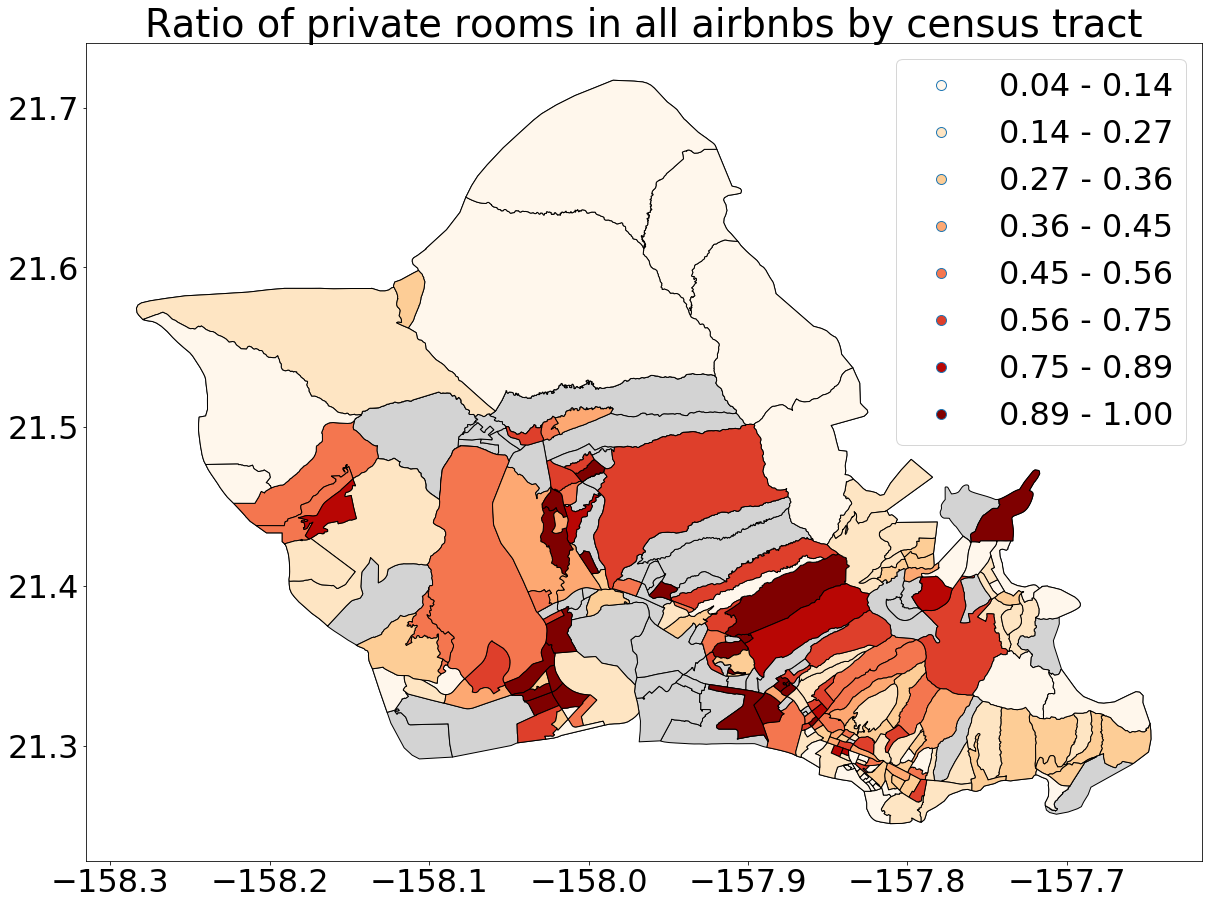

In [64]:
ax = tract.plot(color="lightgrey",linewidth=1, edgecolor='black')
tract2 = tract[~np.isnan(tract['r_private_room'])]
tract2.plot(ax=ax,column='r_private_room',cmap='OrRd', scheme='fisher_jenks',k=8, linewidth=1, edgecolor='black', legend=True)
plt.title('Ratio of private rooms in all airbnbs by census tract')

** Plot airbnbs by room types ** 

In [65]:
geo_listing.columns

Index([                   u'id',           u'listing_url',
                   u'scrape_id',          u'last_scraped',
                        u'name',               u'summary',
                       u'space',           u'description',
         u'experiences_offered', u'neighborhood_overview',
       ...
                    u'NAMELSAD',                 u'ALAND',
                      u'AWATER',            u'Shape_Area',
                  u'GEOID_Data',            u'area_sqr_m',
                     u'pop_den',         u'price_per_bed',
                        u'dist',             u'owner_loc'],
      dtype='object', length=115)

Text(0.5,1,'Local or offshore owner')

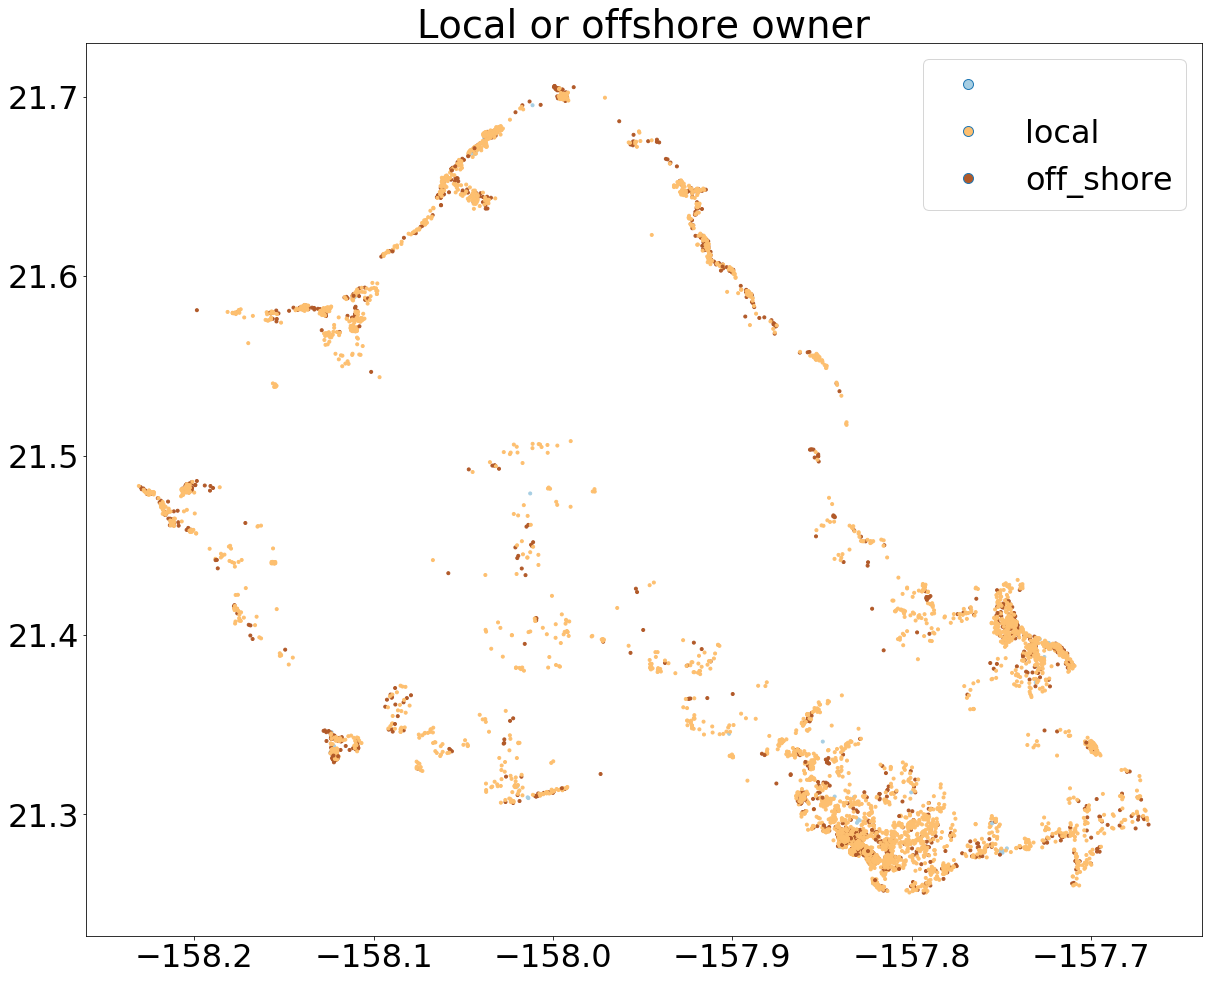

In [66]:
geo_listing.plot(marker='.',column='owner_loc',cmap='Paired',legend=True)
plt.title('Local or offshore owner')

Text(0.5,1,'Ratio of offshore owner by census tract')

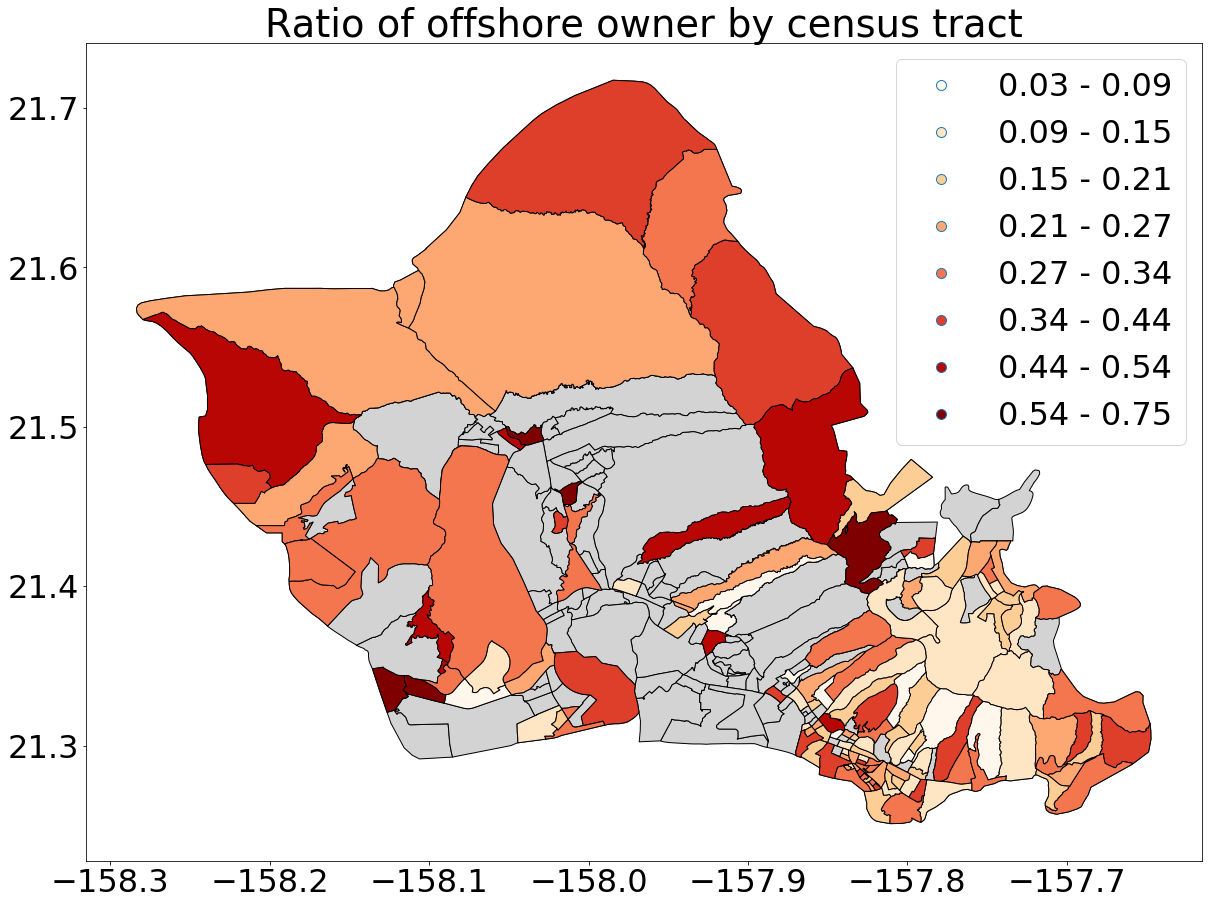

In [67]:
ax = tract.plot(color="lightgrey",linewidth=1, edgecolor='black')
tract['r_offshore_owner']=tract['offshore_owner']/(tract['offshore_owner']+tract['local_owner'])
tract2 = tract[~np.isnan(tract['r_offshore_owner'])]
tract2.plot(ax=ax,column='r_offshore_owner',cmap='OrRd', scheme='fisher_jenks',k=8, linewidth=1, edgecolor='black', legend=True)
plt.title('Ratio of offshore owner by census tract')

Text(0.5,1,'Price per bed ($) in census tract by census tract')

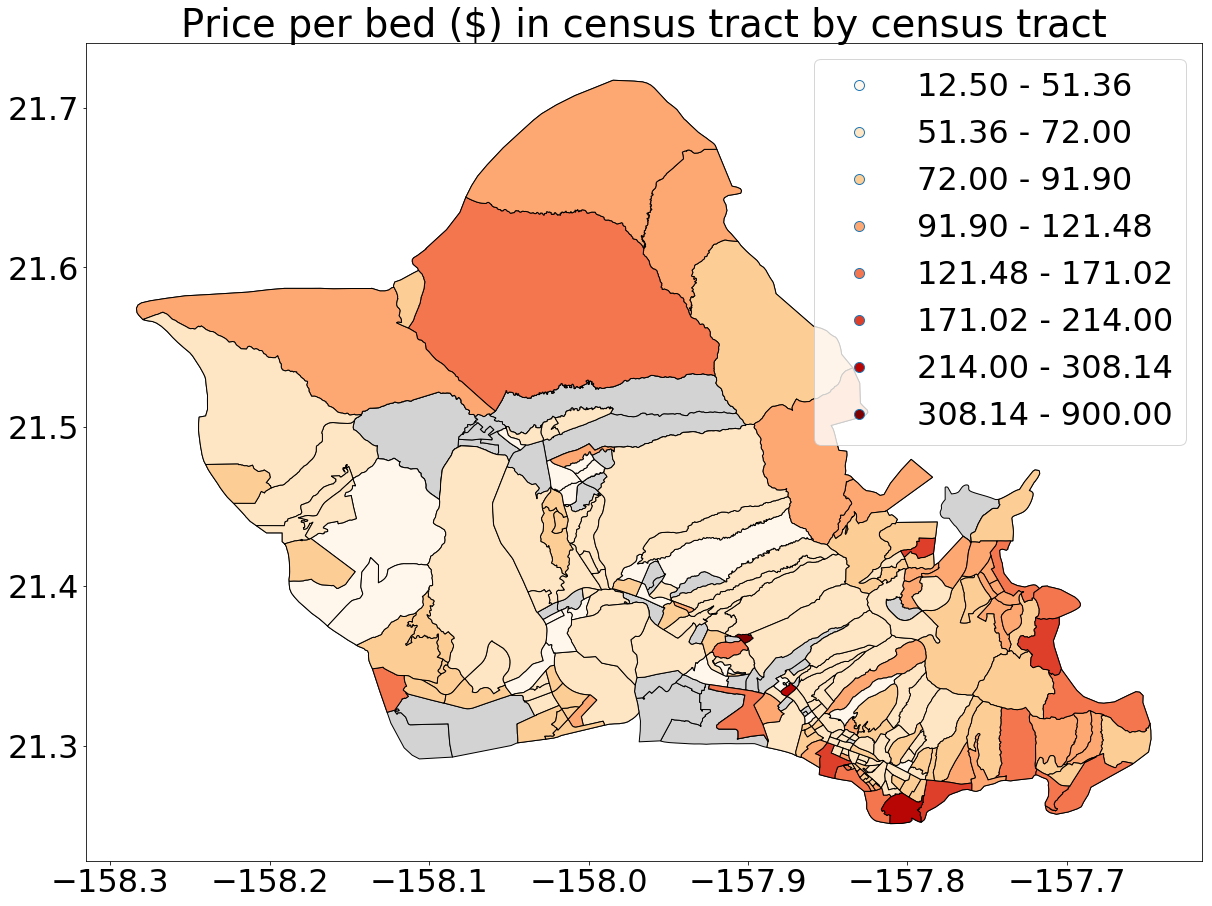

In [68]:
ax = tract.plot(color="lightgrey",linewidth=1, edgecolor='black')
tract2 = tract[~np.isnan(tract['price_per_bed'])]
tract2.plot(ax=ax,column='price_per_bed',cmap='OrRd', scheme='fisher_jenks',k=8, linewidth=1, edgecolor='black', legend=True)
plt.title('Price per bed ($) in census tract by census tract')

** Cancellation policy **

Text(0.5,1,'Cancellation policy')

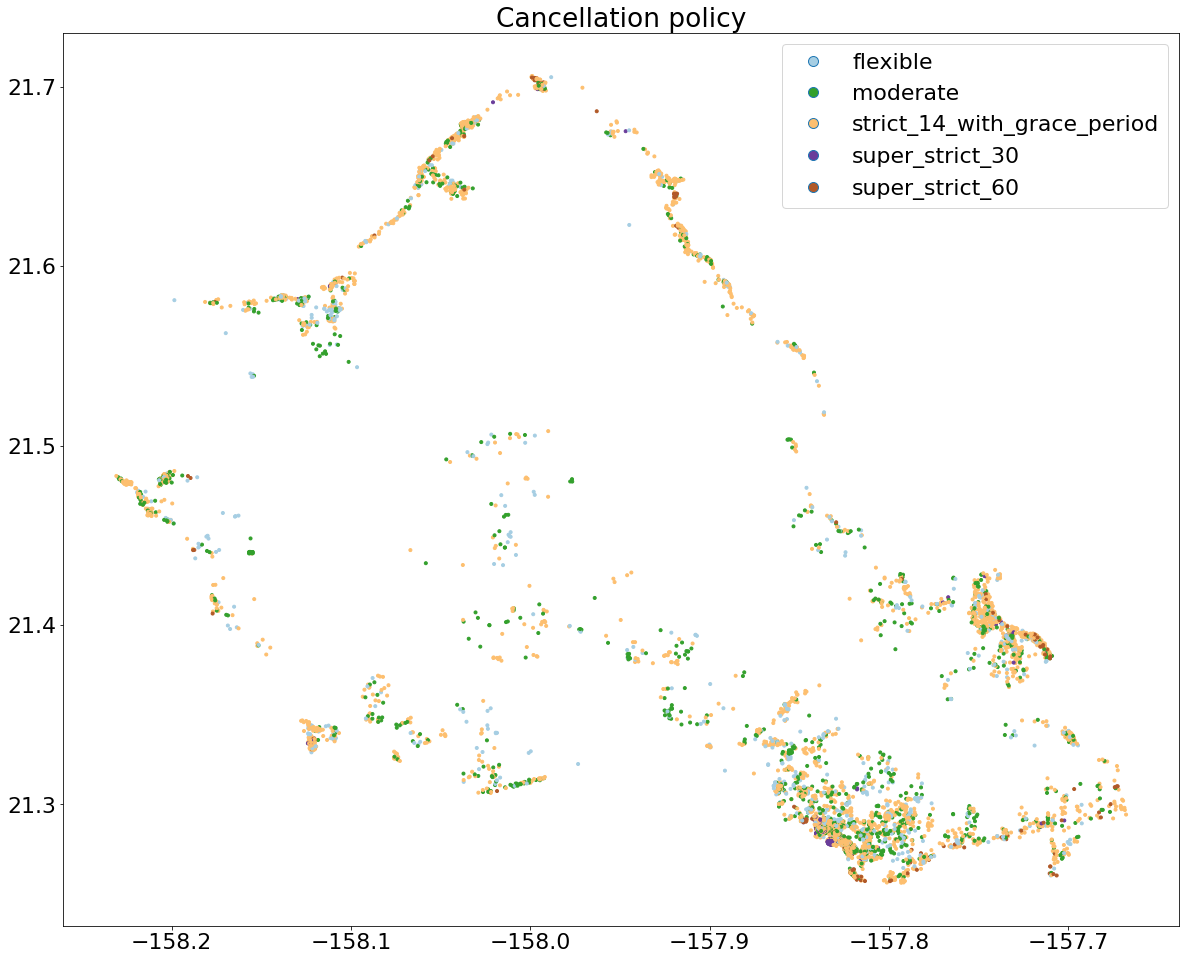

In [69]:
matplotlib.rcParams.update({'font.size': 22})

geo_listing.plot(marker='.',column='cancellation_policy',cmap='Paired',legend=True)
plt.title('Cancellation policy')
